In [58]:
from torch import nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch
import numpy as np
import sys
sys.path.append("BLIP")
from models.blip import BLIP_Base,load_checkpoint
import json

# TF-IDF KNN

In [59]:
from functools import cache
from collections import deque
from math import log
from typing import Deque,Dict,List,Tuple
import nltk
import random

def get_tf(text):
    tokenized = nltk.word_tokenize(text)

    freq = {}
    for token in tokenized:
        token = token.lower()
        if token not in freq:
            freq[token] = 0
        
        freq[token] += 1
    return freq

class TF_IDF_Doc:
    def __init__(self):
        pass

    def get_num_tokens(self) -> int:
        pass

    def get_freq(self, term : str) -> int:
        pass

    def get_all_freq(self) -> Dict[str, int]:
        pass

    def get_text(self):
        pass

    def __lt__(self, other):
        return 0

class TF_IDF_Doc_Text(TF_IDF_Doc):
    def __init__(self, text : str):
        self.text : str = text
        
        tokenized = nltk.word_tokenize(text)
        self.freqs : Dict[str, int] = {}
        self.num_tokens : int = 0

        for token in tokenized:
            token = token.lower()
            if token not in self.freqs:
                self.freqs[token] = 0
            self.freqs[token] += 1
            self.num_tokens += 1

    def get_num_tokens(self) -> int:
        return self.num_tokens

    def get_freq(self, term : str) -> int:
        term = term.lower()
        return self.freqs[term] if term in self.freqs else 0
        
    def get_all_freq(self) -> Dict[str, int]:
        return self.freqs
    
    def get_text(self) -> str:
        return self.text

class TF_IDF_KNN:
    def __init__(self, k=3, capacity=100):
        self.k = k
        self.capacity = capacity

        self.documents : List[Tuple[TF_IDF_Doc, int]] = [] # Possible to optimize, (Doc, class)
        self.size = 0
        self.df : Dict[str, int] = {}
        
    def get_idf(self, token) -> float:
        df = self.df[token] if token in self.df else 0
        N = self.size

        # + 1 to account for df = 0
        return log((N+1) / (df+1))
    
    def add_doc(self, doc : TF_IDF_Doc, cls : int):
        self.size += 1
        # Remove oldest document
        if self.size > self.capacity:
            removed_freq = self.documents[0][0].get_all_freq()
            # Subtract frequencies
            for term, freq in removed_freq.items():
                self.df[term] -= 1 if freq > 0 else 0
                if self.df[term]==0: del self.df[term]
            self.documents = self.documents[1:]
            
            self.size -= 1

        # Add new doc
        self.documents.append((doc, cls))
        
        add_freq = doc.get_all_freq()
        for term, freq in add_freq.items():
            if term not in self.df: self.df[term] = 0
            self.df[term] += 1 if freq > 0 else 0

    def get_tf_idf(self, doc : TF_IDF_Doc) -> Dict[str, float]:
        return {token : (tf/doc.get_num_tokens())*self.get_idf(token) for token,tf in doc.get_all_freq().items()}

    def knn(self, query : TF_IDF_Doc) -> List[TF_IDF_Doc]:
        query_tf_idf = self.get_tf_idf(query)
        query_tf_idf_norm = sum(query_tf_idf.values())

        if query_tf_idf_norm<=0: return -1

        # Possible to use priority queue
        knn_res : List[Tuple[float, int, TF_IDF_Doc]] = []
        for doc,cls in self.documents:
            doc_tf_idf = self.get_tf_idf(doc)
            doc_tf_idf_norm = sum(doc_tf_idf.values())

            if doc_tf_idf_norm <= 0: return -1

            doc_cos_sim = 0
            # Compute dot product
            for term,tf_idf in query_tf_idf.items():
                if term not in doc_tf_idf: continue

                doc_cos_sim += doc_tf_idf[term]*tf_idf

            # Divide by norms
            doc_cos_sim /= query_tf_idf_norm * doc_tf_idf_norm

            if len(knn_res) < self.k:
                knn_res.append((doc_cos_sim, cls, doc))
                knn_res.sort()
            elif knn_res[0][0] < doc_cos_sim:
                knn_res[0] = (doc_cos_sim, cls, doc)
                knn_res.sort()
                
        # Find most frequent class
        cls_freq = {}
        max_cls = []
        for score,cls,doc in knn_res:
            if cls not in cls_freq:
                cls_freq[cls] = 0
            
            cls_freq[cls] += 1
            if len(max_cls)==0 or cls_freq[cls] > cls_freq[max_cls[0]]:
                max_cls = [cls]
            elif cls_freq[cls] == cls_freq[max_cls[0]]:
                max_cls.append(cls)
        if len(max_cls) < 0: return -1
        return random.choice(max_cls)
    
test = TF_IDF_KNN()
doc1 = TF_IDF_Doc_Text("Hello world!")
doc2 = TF_IDF_Doc_Text("Hello world!")
doc3 = TF_IDF_Doc_Text("Goodbye world!")
doc4 = TF_IDF_Doc_Text("Goodbye world!")
doc5 = TF_IDF_Doc_Text("Goodbye world!")
doc6 = TF_IDF_Doc_Text("Goodbye world!")
test.add_doc(doc1, 0)
test.add_doc(doc2, 0)
test.add_doc(doc3, 1)
test.add_doc(doc4, 1)
test.add_doc(doc5, 1)
test.add_doc(doc6, 1)

doc7 = TF_IDF_Doc_Text("Hello everyone!")
print(test.knn(doc7))
doc8 = TF_IDF_Doc_Text("Goodbye everyone!")
print(test.knn(doc8))

0
1


In [60]:
import pandas

df_dataset = pandas.read_csv("../datasets/main_val.csv", delimiter="\t")
df_train = df_dataset[df_dataset["split"]=="train"]
df_valid = df_dataset[df_dataset["split"]=="valid"]

In [69]:
from tqdm import tqdm

def validate(tf_idf_knn : TF_IDF_KNN):
    fp,fn,tp,tn = 0,0,0,0
    for idx, content in df_valid.iterrows():
        result = tf_idf_knn.knn(TF_IDF_Doc_Text(content["text"]))
        if content["label"]==1 and result==1: tp += 1
        if content["label"]==1 and result==0: fn += 1
        if content["label"]==0 and result==1: fp += 1
        if content["label"]==0 and result==0: tn += 1
    return fp,fn,tp,tn

train = list(df_train.iterrows())
random.shuffle(train)

metric_history = []

knn = TF_IDF_KNN(k=5, capacity=100)
for idx,(_,content) in tqdm(list(enumerate(train))):
    knn.add_doc(TF_IDF_Doc_Text(content["text"]), content["label"])

    if idx > 0 and idx%10==0:
        metric_history.append((idx, validate(knn)))

100%|██████████| 1660/1660 [01:15<00:00, 21.97it/s]


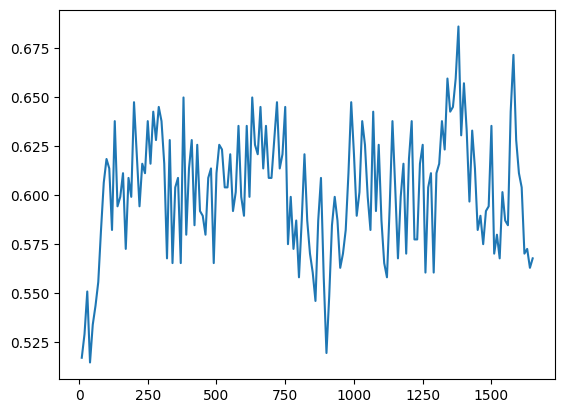

In [70]:
import matplotlib.pyplot as plt

plt.plot([metric[0] for metric in metric_history], [sum(metric[1][2:])/sum(metric[1]) for metric in metric_history])

In [71]:
metric_history

[(10, (41, 159, 51, 163)),
 (20, (45, 150, 60, 159)),
 (30, (50, 136, 74, 154)),
 (40, (79, 122, 88, 125)),
 (50, (72, 121, 89, 132)),
 (60, (76, 113, 97, 128)),
 (70, (87, 97, 113, 117)),
 (80, (84, 89, 121, 120)),
 (90, (69, 94, 116, 135)),
 (100, (80, 78, 132, 124)),
 (110, (80, 80, 130, 124)),
 (120, (106, 67, 143, 98)),
 (130, (76, 74, 136, 128)),
 (140, (104, 64, 146, 100)),
 (150, (88, 78, 132, 116)),
 (160, (96, 65, 145, 108)),
 (170, (89, 88, 122, 115)),
 (180, (58, 104, 106, 146)),
 (190, (92, 74, 136, 112)),
 (200, (55, 91, 119, 149)),
 (210, (63, 94, 116, 141)),
 (220, (100, 68, 142, 104)),
 (230, (77, 82, 128, 127)),
 (240, (80, 81, 129, 124)),
 (250, (73, 77, 133, 131)),
 (260, (82, 77, 133, 122)),
 (270, (61, 87, 123, 143)),
 (280, (82, 72, 138, 122)),
 (290, (54, 93, 117, 150)),
 (300, (75, 75, 135, 129)),
 (310, (66, 93, 117, 138)),
 (320, (70, 109, 101, 134)),
 (330, (61, 93, 117, 143)),
 (340, (91, 89, 121, 113)),
 (350, (61, 103, 107, 143)),
 (360, (82, 80, 130, 122